# *Caso de Estudio Nhanes* #

El Estudio Nacional de Examen de Salud y Nutrición (National Health and Nutrition Examination Survey, NHANES) es un programa de encuestas diseñado para evaluar la salud y el estado nutricional de adultos y niños en los Estados Unidos. A través de entrevistas y exámenes físicos, NHANES recopila datos que ayudan a comprender las condiciones prevalentes en la población, como enfermedades crónicas, deficiencias nutricionales, y problemas de salud mental, incluyendo la depresión.

## *Etapa 1: Comprensión del Negocio*

El objetivo de este estudio es (rellenar)

### Inicio

In [2]:
%load_ext kedro.ipython
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import mstats
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import KNNImputer

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [3]:
demografia = catalog.load("demografia")
insulina = catalog.load("insulina")
colesterol = catalog.load("colesterol")
depresion = catalog.load("depresion")
proteinaC = catalog.load("proteinaC")
perfilB = catalog.load("perfilBioquimico")
scaler = StandardScaler()
minmax = MinMaxScaler()
pt = PowerTransformer(method='yeo-johnson')
pd.options.display.float_format = '{:.2f}'.format

[09/08/24 15:43:56] INFO     Loading data from demografia (ParquetDataset)...                   ]8;id=782740;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=334435;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from insulina (ParquetDataset)...                     ]8;id=519444;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=362396;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from colesterol (ParquetDataset)...                   ]8;id=772162;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=719811;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from depresion (ParquetDataset)...                    ]8;id=685607;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=432665;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from proteinaC (ParquetDataset)...                    ]8;id=913092;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=328407;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

                    INFO     Loading data from perfilBioquimico (ParquetDataset)...             ]8;id=215543;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=260793;file://C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

# Dataframes

In [4]:
consideracion = pd.DataFrame()
consideracion["ID"] = demografia["SEQN"]
consideracion["Edad"] = demografia["RIDAGEYR"]
consideracion["Genero"] = demografia["RIAGENDR"] #1 = hombre; 2= mujer
consideracion["Raza"] = demografia["RIDRETH3"] # 1 = mexico; 2 = otro hispano; 3 = Blanco; 4= negro; 6= asiatico; 7 = otro
consideracion["Educacion"] = demografia["DMDEDUC2"] #ver nhanes
consideracion["EstadoCivil"] = demografia["DMDMARTZ"]
consideracion["NivelPobreza"] = demografia["INDFMPIR"]

In [5]:
insulina['SEQN'] = insulina['SEQN'].astype(int)
insulina = insulina.rename(columns={'SEQN': 'ID'})
insulina = insulina.rename(columns={'WTSAFPRP': "Peso de Submuestra en Ayunas"})
insulina = insulina.rename(columns={'LBXIN': "Insulina (μU/mL)"})
insulina = insulina.rename(columns={'LBDINSI': "Insulina (pmol/L)"})
insulina = insulina.rename(columns={'LBDINLC': "Código de Comentario de Insulina"})

In [30]:
Q1 = insulina["Insulina (μU/mL)"].quantile(0.25)
Q3 = insulina["Insulina (μU/mL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers = insulina[(insulina["Insulina (μU/mL)"] < lower_bound) | (insulina["Insulina (μU/mL)"] > upper_bound)]

# Removing outliers
consideracion_insulina_limpio = insulina[~((insulina["Insulina (μU/mL)"] < lower_bound) | (insulina["Insulina (μU/mL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers)

print(num_outliers)

 El IQR es 10.3. El límite inferior es: -9.14, el superior es 32.06
310


In [33]:
escalado = scaler.fit_transform(consideracion_insulina_limpio[["Insulina (μU/mL)"]])
insulina_escalado = consideracion_insulina_limpio.copy()
insulina_escalado["Insulina (μU/mL)"]=escalado

In [48]:
Q1 = insulina_escalado["Insulina (μU/mL)"].quantile(0.25)
Q3 = insulina_escalado["Insulina (μU/mL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers = insulina_escalado[(insulina_escalado["Insulina (μU/mL)"] < lower_bound) | (insulina_escalado["Insulina (μU/mL)"] > upper_bound)]

# Removing outliers
limpieza_insulina = insulina_escalado[~((insulina_escalado["Insulina (μU/mL)"] < lower_bound) | (insulina_escalado["Insulina (μU/mL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers)

print(num_outliers)

 El IQR es 1.2941829291513374. El límite inferior es: -2.6984244447452377, el superior es 2.478307271860112
115


In [50]:
knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")
insulina_limpia = limpieza_insulina.copy()
insulina_limpia["Insulina (μU/mL)"] = knn_imputer.fit_transform(limpieza_insulina[["Insulina (μU/mL)"]])

In [51]:
insulina_limpia["Insulina (μU/mL)"] = pt.fit_transform(insulina_limpia[["Insulina (μU/mL)"]])

[09/08/24 15:58:17] WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=273678;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=646228;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

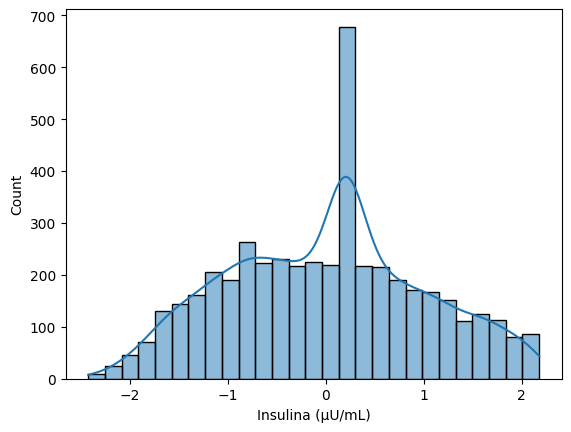

In [52]:
sns.histplot(data=insulina_limpia, x="Insulina (μU/mL)", kde=True)
plt.show()

In [6]:
colesterol = colesterol.rename(columns={
    'SEQN': 'ID',
    'LBXTC': 'Colesterol Total (mg/dL)',
    'LBDTCSI': 'Colesterol Total (mmol/L)'
})

In [40]:
Q1 = colesterol["Colesterol Total (mg/dL)"].quantile(0.25)
Q3 = colesterol["Colesterol Total (mg/dL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers_colesterol = colesterol[(colesterol["Colesterol Total (mg/dL)"] < lower_bound) | (colesterol["Colesterol Total (mg/dL)"] > upper_bound)]

# Removing outliers
consideracion_colesterol_limpio = colesterol[~((colesterol["Colesterol Total (mg/dL)"] < lower_bound) | (colesterol["Colesterol Total (mg/dL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers_colesterol)

print(num_outliers)

 El IQR es 52.0. El límite inferior es: 71.0, el superior es 279.0
177


In [42]:
knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")
colesterol_limpio = consideracion_colesterol_limpio.copy()
colesterol_limpio["Colesterol Total (mg/dL)"] = knn_imputer.fit_transform(colesterol_limpio[["Colesterol Total (mg/dL)"]])

[09/08/24 15:58:48] WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=736076;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=363971;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

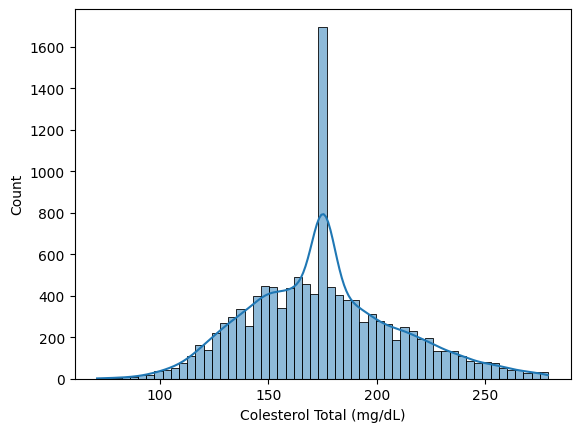

In [53]:
sns.histplot(data=colesterol_limpio, x="Colesterol Total (mg/dL)", kde=True)
plt.show()

In [54]:
colesterol_limpio["Colesterol Total (mg/dL)"] = pt.fit_transform(colesterol_limpio[["Colesterol Total (mg/dL)"]])

In [43]:
prueba = pd.DataFrame()
prueba["ID"] = demografia["SEQN"]
prueba["Edad"] = demografia["RIDAGEYR"]
prueba["Raza"] = demografia["RIDRETH3"]

In [55]:
merge_insulina = pd.merge(prueba, limp_ins, on='ID', how='inner')

In [56]:
final = pd.merge(merge_insulina, colesterol_limpio, on='ID', how='inner')

In [57]:
final

,ID,Edad,Raza,Peso de Submuestra en Ayunas,Insulina (μU/mL),Insulina (pmol/L),Código de Comentario de Insulina,Colesterol Total (mg/dL),Colesterol Total (mmol/L)
0,109264.00,13.00,1.00,27533.17,-0.78,36.30,0.00,-0.21,4.29
1,109271.00,49.00,3.00,18100.97,1.09,101.76,0.00,-0.80,3.80
2,109274.00,68.00,7.00,16281.76,0.67,81.12,0.00,-2.29,2.72
3,109277.00,12.00,1.00,32230.05,-0.68,38.64,0.00,-1.40,3.34
4,109282.00,76.00,3.00,79007.10,-0.43,44.94,0.00,1.58,6.03
...,...,...,...,...,...,...,...,...,...
4572,124813.00,43.00,4.00,31057.93,-0.28,49.14,0.00,-0.48,4.06
4573,124814.00,64.00,4.00,9339.90,-0.48,43.62,0.00,1.38,5.82
4574,124815.00,52.00,4.00,75210.18,-0.52,42.60,0.00,0.82,5.25
4575,124821.00,63.00,4.00,10704.47,-0.37,46.50,0.00,-0.55,4.01


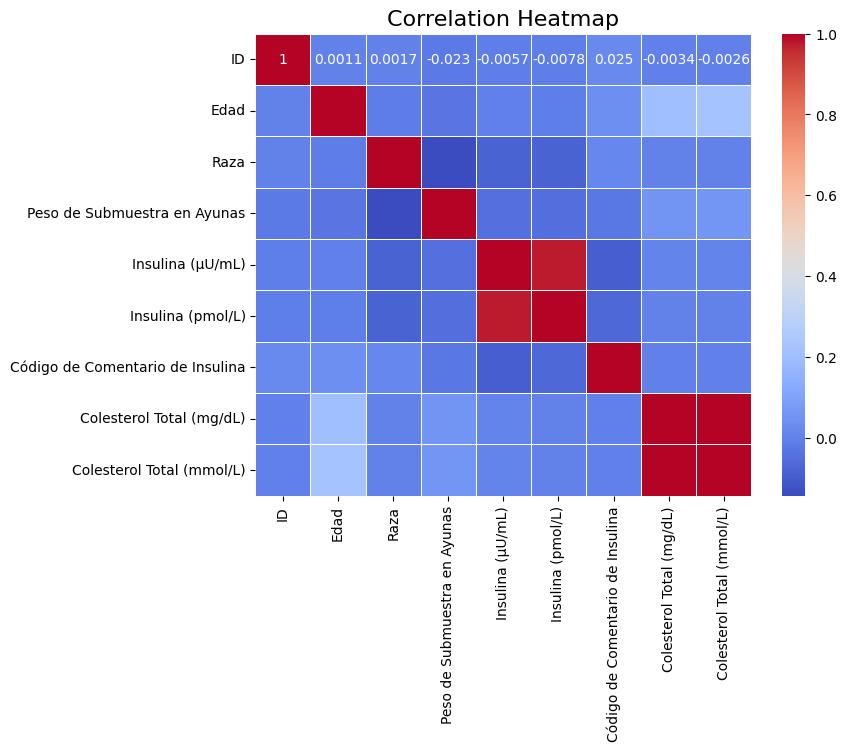

In [58]:
corr_matrix = final.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Set titles and labels
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

In [10]:

consideracion[consideracion["NivelPobreza"]<1]

,ID,Edad,Genero,Raza,Educacion,EstadoCivil,NivelPobreza
1,109264.00,13.00,2.00,1.00,NaN,NaN,0.83
6,109269.00,2.00,1.00,2.00,NaN,NaN,0.96
9,109272.00,0.00,1.00,1.00,NaN,NaN,0.73
10,109273.00,36.00,1.00,3.00,4.00,3.00,0.83
13,109276.00,0.00,1.00,4.00,NaN,NaN,0.00
...,...,...,...,...,...,...,...
15524,124787.00,19.00,2.00,4.00,NaN,NaN,0.80
15529,124792.00,32.00,1.00,2.00,5.00,3.00,0.00
15535,124798.00,55.00,1.00,2.00,1.00,3.00,0.80
15543,124806.00,4.00,2.00,4.00,NaN,NaN,0.38


In [11]:
for columna in consideracion.columns:
    if consideracion[columna].isna().sum() != 0:
        print(f"Columna {columna} tiene {consideracion[columna].isna().sum()} NaN")

Columna Educacion tiene 6328 NaN
Columna EstadoCivil tiene 6328 NaN
Columna NivelPobreza tiene 2201 NaN


In [12]:
consideracion.loc[consideracion["Edad"] <= 13, "Educacion"] = consideracion.loc[consideracion["Edad"] <= 13, "Educacion"].fillna(1)
consideracion.loc[consideracion["Edad"] <= 19, "Educacion"] = consideracion.loc[consideracion["Edad"] <= 19, "Educacion"].fillna(2)
consideracion.loc[consideracion["Edad"] <= 18, "EstadoCivil"] = consideracion.loc[consideracion["Edad"] <= 18, "EstadoCivil"].fillna(3)

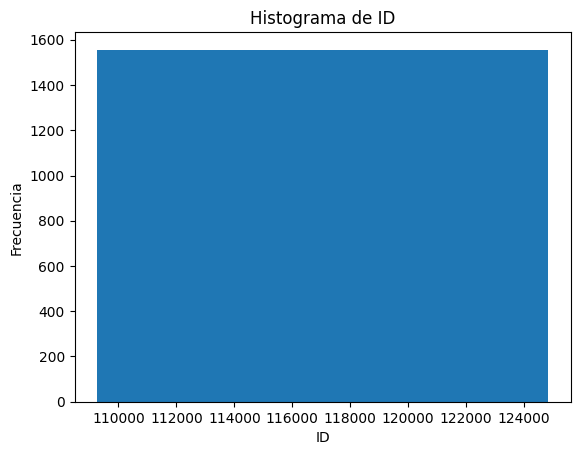

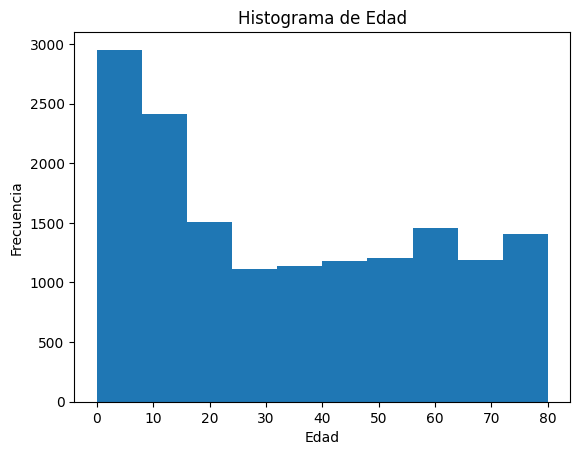

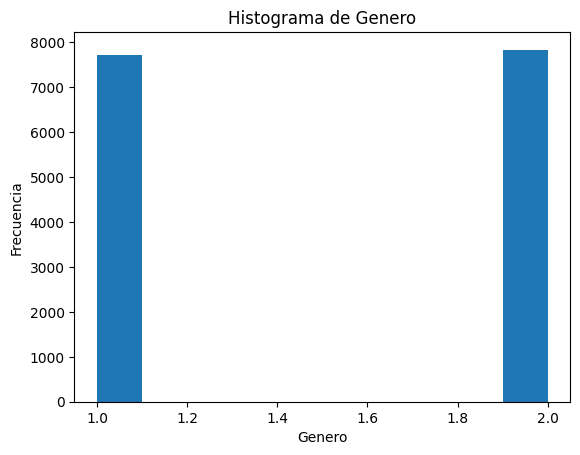

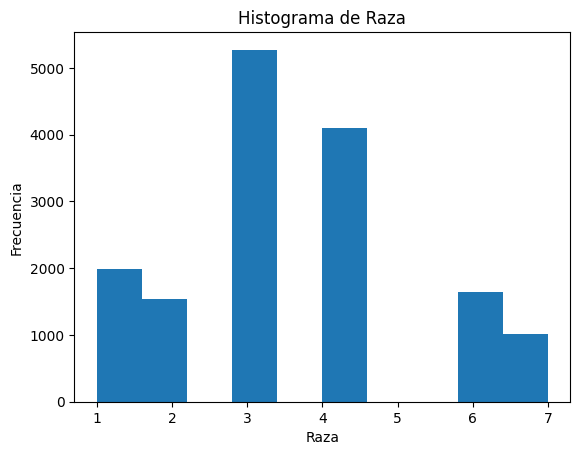

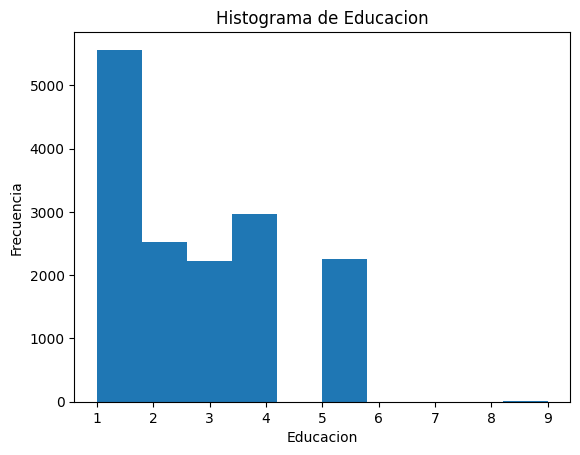

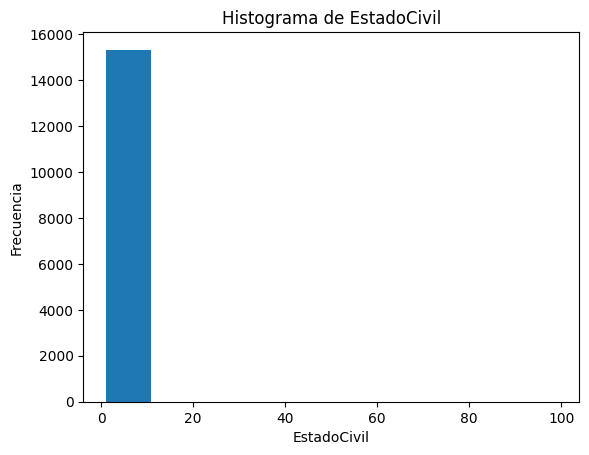

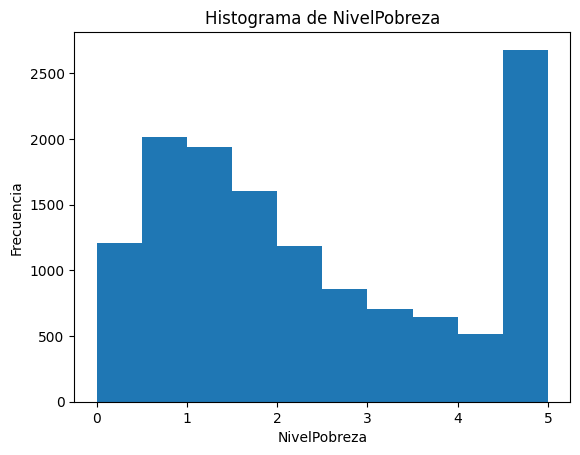

In [13]:
for col in consideracion.columns:
  plt.hist(consideracion[col])
  plt.title(f'Histograma de {col}')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

In [14]:
consideracion.isna().sum()


ID                 0
Edad               0
Genero             0
Raza               0
Educacion          0
EstadoCivil      227
NivelPobreza    2201
dtype: int64

In [15]:
consideracion = consideracion.loc[consideracion['NivelPobreza'] <5]

In [16]:
pobreza_escalado = scaler.fit_transform(consideracion[['NivelPobreza']])
pobreza_minmax = minmax.fit_transform(consideracion[['NivelPobreza']])
pobreza_pt = pt.fit_transform(consideracion[['NivelPobreza']])
pobreza_sqrt = np.sqrt(consideracion[['NivelPobreza']])
pobreza_boxcox, _ = stats.boxcox(consideracion["NivelPobreza"] + 1)
log_data = np.log1p(consideracion[['NivelPobreza']])

In [17]:
for pobre in [pobreza_boxcox,log_data,pobreza_escalado,pobreza_minmax,pobreza_pt,pobreza_sqrt]:
    df = pd.DataFrame(pobre)
    print(df.describe())

             0
count 11213.00
mean      1.03
std       0.50
min       0.00
25%       0.66
50%       1.02
75%       1.42
max       1.96
       NivelPobreza
count      11213.00
mean           0.97
std            0.45
min            0.00
25%            0.64
50%            0.97
75%            1.32
max            1.79
             0
count 11213.00
mean      0.00
std       1.00
min      -1.49
25%      -0.79
50%      -0.21
75%       0.65
max       2.39
             0
count 11213.00
mean      0.38
std       0.26
min       0.00
25%       0.18
50%       0.33
75%       0.55
max       1.00
             0
count 11213.00
mean      0.00
std       1.00
min      -2.08
25%      -0.74
50%      -0.02
75%       0.77
max       1.88
       NivelPobreza
count      11213.00
mean           1.29
std            0.50
min            0.00
25%            0.95
50%            1.28
75%            1.66
max            2.23


[09/08/24 15:43:57] WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=762485;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=126253;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=904717;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=432805;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=849438;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=267980;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=519299;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=633354;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

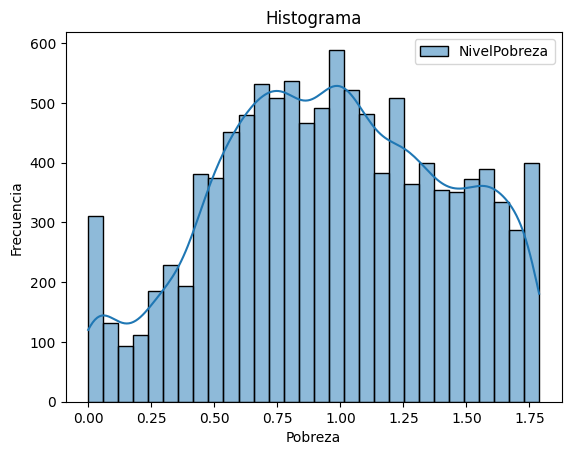

[09/08/24 15:43:58] WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=533800;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=348166;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=679009;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=71218;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

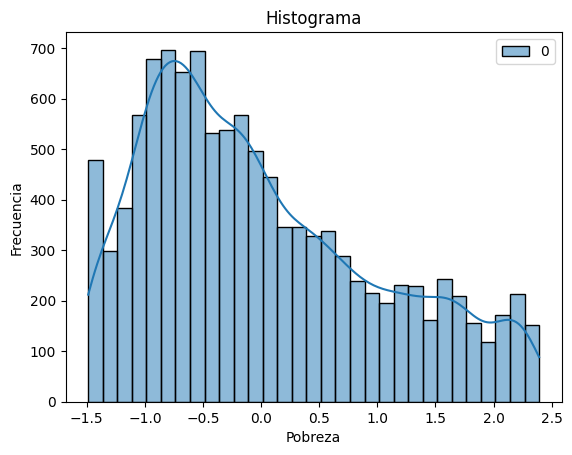

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=269386;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=812816;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=665742;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=289955;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

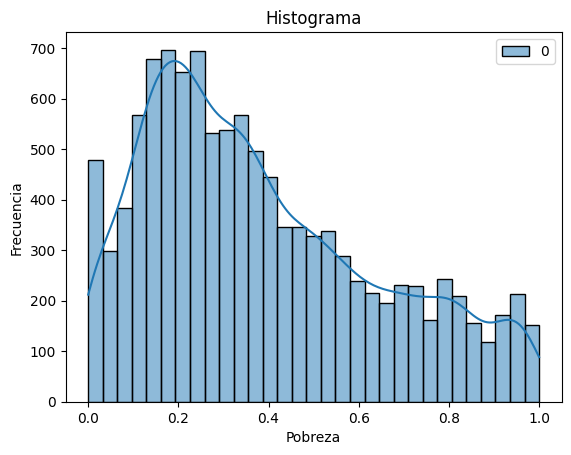

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=883020;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=59736;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=602559;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=766846;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

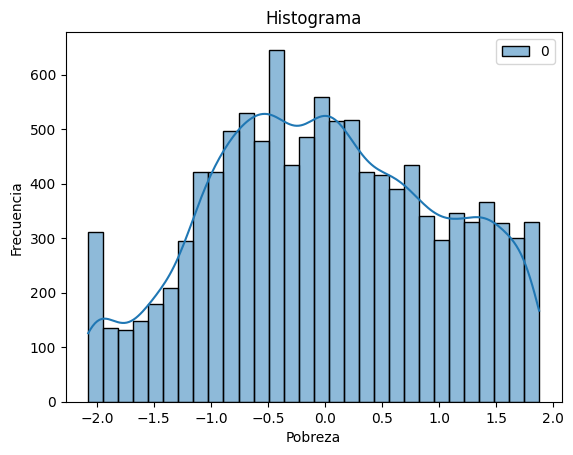

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=414426;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=346485;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1119: FutureWarning: use_inf_as_na option is deprecated and will be                
                             removed in a future version. Convert inf values to NaN before                         
                             operating instead.                                                                    
                               with pd.option_context('mode.use_inf_as_na', True):                                 
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=789234;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=178842;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

[09/08/24 15:43:59] WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=18064;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=517437;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

                    WARNING  C:\Users\crist\desktop\kedro\.venv\Lib\site-packages\seaborn\_oldcore. ]8;id=279476;file://C:\Python311\Lib\warnings.py\warnings.py]8;;\:]8;id=100369;file://C:\Python311\Lib\warnings.py#109\109]8;;\
                             py:1075: FutureWarning: When grouping with a length-1 list-like, you                  
                             will need to pass a length-1 tuple to get_group in a future version of                
                             pandas. Pass `(name,)` instead of `name` to silence this warning.                     
                               data_subset = grouped_data.get_group(pd_key)                                        
                                                                                                                   

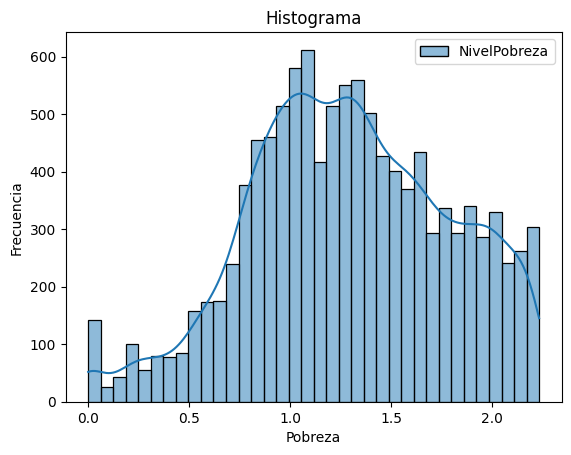

In [18]:
for pobre in [log_data,pobreza_escalado,pobreza_minmax,pobreza_pt,pobreza_sqrt]:
    sns.histplot(data=pobre, kde=True)
    plt.title(f'Histograma')
    plt.xlabel("Pobreza")
    plt.ylabel('Frecuencia')
    plt.show()

In [19]:
consideracion['NivelPobreza'] = pobreza_sqrt

In [20]:
knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")
consideracion['NivelPobreza'] = knn_imputer.fit_transform(pobreza_sqrt[['NivelPobreza']])
consideracion

,ID,Edad,Genero,Raza,Educacion,EstadoCivil,NivelPobreza
0,109263.00,2.00,1.00,6.00,1.00,3.00,2.16
1,109264.00,13.00,2.00,1.00,1.00,3.00,0.91
2,109265.00,2.00,1.00,3.00,1.00,3.00,1.75
5,109268.00,18.00,2.00,3.00,2.00,3.00,1.29
6,109269.00,2.00,1.00,2.00,1.00,3.00,0.98
...,...,...,...,...,...,...,...
15554,124817.00,67.00,2.00,1.00,2.00,1.00,1.48
15555,124818.00,40.00,1.00,4.00,5.00,1.00,1.95
15556,124819.00,2.00,1.00,4.00,1.00,3.00,0.26
15557,124820.00,7.00,2.00,3.00,1.00,3.00,1.10


In [21]:
consideracion["NivelPobreza"].describe()


count   11213.00
mean        1.29
std         0.50
min         0.00
25%         0.95
50%         1.28
75%         1.66
max         2.23
Name: NivelPobreza, dtype: float64

In [22]:
consideracion.isna().sum()


ID                0
Edad              0
Genero            0
Raza              0
Educacion         0
EstadoCivil     173
NivelPobreza      0
dtype: int64

In [23]:
#consideracion = consideracion.dropna()

In [24]:
consideracion["Educacion"].isna().sum()

np.int64(0)

In [25]:
consideracion["NivelPobreza"].describe()


count   11213.00
mean        1.29
std         0.50
min         0.00
25%         0.95
50%         1.28
75%         1.66
max         2.23
Name: NivelPobreza, dtype: float64

# Combinación de dataset con Insulina

In [ ]:
consideracion_insulina = pd.merge(consideracion, insulina, on='ID', how='inner')

In [ ]:
consideracion_insulina.describe()

In [ ]:
Q1 = consideracion_insulina["Insulina (μU/mL)"].quantile(0.25)
Q3 = consideracion_insulina["Insulina (μU/mL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers = consideracion_insulina[(consideracion_insulina["Insulina (μU/mL)"] < lower_bound) | (consideracion_insulina["Insulina (μU/mL)"] > upper_bound)]

# Removing outliers
consideracion_insulina_limpio = consideracion_insulina[~((consideracion_insulina["Insulina (μU/mL)"] < lower_bound) | (consideracion_insulina["Insulina (μU/mL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers)

print(num_outliers)


In [ ]:
Q1 = consideracion_insulina_limpio["Insulina (μU/mL)"].quantile(0.25)
Q3 = consideracion_insulina_limpio["Insulina (μU/mL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers = consideracion_insulina_limpio[(consideracion_insulina_limpio["Insulina (μU/mL)"] < lower_bound) | (consideracion_insulina_limpio["Insulina (μU/mL)"] > upper_bound)]

# Removing outliers
insulina_limpio = consideracion_insulina_limpio[~((consideracion_insulina_limpio["Insulina (μU/mL)"] < lower_bound) | (consideracion_insulina_limpio["Insulina (μU/mL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers)

print(num_outliers)

In [ ]:
insulina_limpio.isna().sum()

In [ ]:
insulina_limpio.describe()

In [ ]:
plt.hist(insulina_limpio["Insulina (μU/mL)"])
plt.title(f'Histograma de {"Insulina (μU/mL)"}')
plt.xlabel("Insulina (μU/mL)")
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
for col in insulina_limpio.columns[7:-1]:
  plt.hist(insulina_limpio[col])
  plt.title(f'Histograma de {col}')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

In [ ]:
escalado = scaler.fit_transform(insulina_limpio[["Insulina (μU/mL)"]])
minmaxesc = minmax.fit_transform(insulina_limpio[["Insulina (μU/mL)"]])
powerTrans = pt.fit_transform(insulina_limpio[["Insulina (μU/mL)"]])

In [ ]:
insulina_escalado = insulina_limpio.copy()
insulina_minmax = insulina_limpio.copy()
insulina_power = insulina_limpio.copy()
insulina_escalado["Insulina (μU/mL)"]=escalado
insulina_minmax["Insulina (μU/mL)"]=minmaxesc
insulina_power["Insulina (μU/mL)"]=powerTrans

In [ ]:
for col in insulina_escalado.columns[7:-1]:
  plt.hist(insulina_escalado[col])
  plt.title(f'Histograma de {col}')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

In [ ]:
for col in insulina_minmax.columns[7:-1]:
  plt.hist(insulina_minmax[col])
  plt.title(f'Histograma de {col}')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

In [ ]:
Q1 = insulina_escalado["Insulina (μU/mL)"].quantile(0.25)
Q3 = insulina_escalado["Insulina (μU/mL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers = insulina_escalado[(insulina_escalado["Insulina (μU/mL)"] < lower_bound) | (insulina_escalado["Insulina (μU/mL)"] > upper_bound)]

# Removing outliers
limpieza_insulina = insulina_escalado[~((insulina_escalado["Insulina (μU/mL)"] < lower_bound) | (insulina_escalado["Insulina (μU/mL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers)

print(num_outliers)

In [ ]:
limp_ins = limpieza_insulina.copy()
limp_ins["Insulina (μU/mL)"] = pt.fit_transform(limp_ins[["Insulina (μU/mL)"]])

In [ ]:
for col in insulina_power.columns[7:-1]:
  sns.histplot(data=limp_ins, x=col, kde=True)
  plt.title(f'Histograma de {col}')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

In [ ]:
limp_ins.isna().sum()

In [ ]:
knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")
limp_ins["Insulina (μU/mL)"] = knn_imputer.fit_transform(limp_ins[["Insulina (μU/mL)"]])

In [ ]:
plt.hist(limp_ins["Edad"])
plt.title(f'Histograma')
plt.xlabel("Edad")
plt.ylabel('Frecuencia')
plt.show()

In [ ]:

limp_ins["Edad"], lambda_opt = boxcox(limp_ins["Edad"] + 1)

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(limp_ins["Edad"], bins=30)
plt.title('Original Data (Right-Skewed)')
plt.show()

In [ ]:
corr_matrix = limp_ins.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Set titles and labels
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

Conclusión: SIGUE SIN HABER RELACIÓN >:(

In [ ]:
#insulina_nonna = consideracion_insulina.dropna()

# Combinación de Dataset con Colesterol

In [ ]:
colesterol = colesterol.rename(columns={
    'SEQN': 'ID',
    'LBXTC': 'Colesterol Total (mg/dL)',
    'LBDTCSI': 'Colesterol Total (mmol/L)'
})

In [ ]:
consideracion_colesterol = pd.merge(consideracion, colesterol, on='ID', how='inner')

In [ ]:
consideracion_colesterol.head()

In [ ]:
consideracion_colesterol.describe()

In [ ]:
for col in consideracion_colesterol.columns[7:]:
  plt.hist(consideracion_colesterol[col])
  plt.title(f'Histograma de {col} pre IQR')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

In [ ]:
Q1 = consideracion_colesterol["Colesterol Total (mg/dL)"].quantile(0.25)
Q3 = consideracion_colesterol["Colesterol Total (mg/dL)"].quantile(0.75)
IQR = Q3 - Q1

# Calculating the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

# Identifying outliers
outliers_colesterol = consideracion_colesterol[(consideracion_colesterol["Colesterol Total (mg/dL)"] < lower_bound) | (consideracion_colesterol["Colesterol Total (mg/dL)"] > upper_bound)]

# Removing outliers
consideracion_colesterol_limpio = consideracion_colesterol[~((consideracion_colesterol["Colesterol Total (mg/dL)"] < lower_bound) | (consideracion_colesterol["Colesterol Total (mg/dL)"] > upper_bound))]

# Checking the number of outliers
num_outliers = len(outliers_colesterol)

print(num_outliers)

In [ ]:
for col in consideracion_colesterol_limpio.columns[7:]:
  plt.hist(consideracion_colesterol_limpio[col])
  plt.title(f'Histograma de {col} post IQR')
  plt.xlabel(col)
  plt.ylabel('Frecuencia')
  plt.show()

# Combinación de Dataset con Proteína C Spoiler: No pude lograr la distribución normal en la proteína :(

In [ ]:
proteinaC = proteinaC.rename(columns={
    'SEQN': 'ID',
    'LBXHSCRP': 'Proteína C Reactiva (mg/L)',
    'LBDHRPLC': 'Código de Comentario de Proteína C Reactiva'
})

In [ ]:
consideracion_proteinaC = pd.merge(consideracion, proteinaC, on='ID', how='inner')

In [ ]:
consideracion_proteinaC.isna().sum()

In [ ]:
consideracion_proteinaC.describe()

In [ ]:
Q1 = consideracion_proteinaC["Proteína C Reactiva (mg/L)"].quantile(0.25)
Q3 = consideracion_proteinaC["Proteína C Reactiva (mg/L)"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 0.5 * IQR
upper_bound = Q3 + 0.5 * IQR

print(f" El IQR es {IQR}. El límite inferior es: {lower_bound}, el superior es {upper_bound}")

outliers_proteinac = consideracion_proteinaC[(consideracion_proteinaC["Proteína C Reactiva (mg/L)"] < lower_bound) | (consideracion_proteinaC["Proteína C Reactiva (mg/L)"] > upper_bound)]

proteinac_limpio = consideracion_proteinaC[~((consideracion_proteinaC["Proteína C Reactiva (mg/L)"] < lower_bound) | (consideracion_proteinaC["Proteína C Reactiva (mg/L)"] > upper_bound))]

num_outliers = len(outliers_proteinac)

print(num_outliers)

In [ ]:
proteina_c = proteinac_limpio.copy()
proteina_c[['Proteína C Reactiva (mg/L)']] = knn_imputer.fit_transform(proteina_c[['Proteína C Reactiva (mg/L)']])

In [ ]:
proteina_c.describe()

In [ ]:
pro_c = proteina_c.copy()
pro_c["Proteína C Reactiva (mg/L)"] = minmax.fit_transform(pro_c[["Proteína C Reactiva (mg/L)"]])

In [ ]:
# Aplicar la transformación logarítmica
proteina_c['Proteína C Reactiva (mg/L) Log'] = np.log1p(proteina_c['Proteína C Reactiva (mg/L)'])

# Visualizar la distribución después de la transformación logarítmica
plt.figure(figsize=(10, 6))
sns.histplot(proteina_c['Proteína C Reactiva (mg/L) Log'].dropna(), bins=20, kde=True, color="skyblue")
plt.title('Distribución Logarítmica de la Proteína C Reactiva (mg/L)', fontsize=16)
plt.xlabel('Proteína C Reactiva (mg/L) Log', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

In [ ]:
# Aplicar la transformación Box-Cox (requiere valores positivos)
proteina_c_positive = proteina_c[proteina_c['Proteína C Reactiva (mg/L)'] > 0]
proteina_c['Proteína C Reactiva (mg/L) Box-Cox'], _ = stats.boxcox(proteina_c_positive['Proteína C Reactiva (mg/L)'])

# Visualizar la distribución después de la transformación Box-Cox
plt.figure(figsize=(10, 6))
sns.histplot(proteina_c['Proteína C Reactiva (mg/L) Box-Cox'].dropna(), bins=20, kde=True, color="lightgreen")
plt.title('Distribución Box-Cox de la Proteína C Reactiva (mg/L)', fontsize=16)
plt.xlabel('Proteína C Reactiva (mg/L) Box-Cox', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

In [ ]:
# Aplicar la transformación de raíz cuadrada
proteina_c['Proteína C Reactiva (mg/L) sqrt'] = np.sqrt(proteina_c['Proteína C Reactiva (mg/L)'])

# Visualizar la distribución después de la transformación de raíz cuadrada
plt.figure(figsize=(10, 6))
sns.histplot(proteina_c['Proteína C Reactiva (mg/L) sqrt'].dropna(), bins=20, kde=True, color="coral")
plt.title('Distribución de Raíz Cuadrada de la Proteína C Reactiva (mg/L)', fontsize=16)
plt.xlabel('Proteína C Reactiva (mg/L) sqrt', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

In [ ]:
# Aplicar winsorización a los datos (cap los valores en el percentil 95)
proteina_c['Proteína C Reactiva (mg/L) Winsorizada'] = mstats.winsorize(proteina_c['Proteína C Reactiva (mg/L)'], limits=[0.05, 0.05])

# Visualizar la distribución después de la winsorización
plt.figure(figsize=(10, 6))
sns.histplot(proteina_c['Proteína C Reactiva (mg/L) Winsorizada'].dropna(), bins=20, kde=True, color="lightblue")
plt.title('Distribución Winsorizada de la Proteína C Reactiva (mg/L)', fontsize=16)
plt.xlabel('Proteína C Reactiva (mg/L) Winsorizada', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

# Combinación de Dataset con Depresión

In [ ]:
depresion = depresion.rename(columns={
    'SEQN': 'ID',
    'DPQ010': 'Poco Interés en Hacer Cosas',
    'DPQ020': 'Sentirse Deprimido o Sin Esperanza',
    'DPQ030': 'Problemas para Dormir',
    'DPQ040': 'Cansancio o Poca Energía',
    'DPQ050': 'Poco Apetito o Comer en Exceso',
    'DPQ060': 'Sentirse Mal Acerca de Uno Mismo',
    'DPQ070': 'Problemas de Concentración',
    'DPQ080': 'Movimientos o Hablar Lento o Rápido',
    'DPQ090': 'Pensamientos de Muerte o Autolesión',
    'DPQ100': 'Dificultad que Estos Problemas Causan'
})

In [ ]:
consideracion_depresion = pd.merge(consideracion, depresion, on='ID', how='inner')

In [ ]:
consideracion_depresion

In [ ]:
consideracion_depresion.describe()

In [ ]:
def detectar_outliers_zscore(df, columna, umbral=3):
    z_scores = np.abs(stats.zscore(df[columna].dropna()))
    z_scores_series = pd.Series(z_scores, index=df[columna].dropna().index)
    outliers = df.loc[z_scores_series[z_scores_series > umbral].index]
    return outliers
    
outliers_zscore = detectar_outliers_zscore(depresion, 'Poco Interés en Hacer Cosas')
display(outliers_zscore)

In [ ]:
# Histograma de la columna 'Poca Interés en Hacer Cosas'
plt.figure(figsize=(10, 8))
sns.histplot(depresion['Poco Interés en Hacer Cosas'].dropna(), bins=20, kde=True, color="blue")
plt.title('Distribución de la respuesta: Poco Interés en Hacer Cosas', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks(ticks=[0, 1, 2, 3, 7, 9], labels=['Nada', 'Varios Días', 'Más de la Mitad', 'Casi Todos', 'Rechazado', 'No Sabe'])
plt.xticks(rotation=45)  # Rota las etiquetas del eje X 45 grados
plt.show()

In [ ]:
sns.set(style="whitegrid")

# Pregunta 1: Distribución para 'Poca Interés en Hacer Cosas' (DPQ010)
plt.figure(figsize=(8, 6))
sns.countplot(x='Poco Interés en Hacer Cosas', data=depresion, palette="viridis")
plt.title('Distribución de la Respuesta: Poco Interés en Hacer Cosas')
plt.xlabel('Respuesta')
plt.ylabel('Frecuencia')
plt.xticks(ticks=[0, 1, 2, 3, 7, 9], labels=['Nada', 'Varios Días', 'Más de la Mitad', 'Casi Todos', 'Rechazado', 'No Sabe'])
plt.xticks(rotation=45)  # Rota las etiquetas del eje X 45 grados
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Sentirse Deprimido o Sin Esperanza'].dropna(), bins=10, kde=True, color="lightcoral")
plt.title('Distribución de la Respuesta: Sentirse Deprimido o Sin Esperanza', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Sentirse Deprimido o Sin Esperanza'].dropna(), bins=10, kde=True, color="green")
plt.title('Distribución de la Respuesta: Sentirse Deprimido o Sin Esperanza', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Problemas para Dormir'].dropna(), bins=10, kde=True, color="lightgreen")
plt.title('Distribución de la Respuesta: Problemas para Dormir', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Cansancio o Poca Energía'].dropna(), bins=10, kde=True, color="lightpink")
plt.title('Distribución de la Respuesta: Cansancio o Poca Energía', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Poco Apetito o Comer en Exceso'].dropna(), bins=10, kde=True, color="plum")
plt.title('Distribución de la Respuesta: Poco Apetito o Comer en Exceso', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Sentirse Mal Acerca de Uno Mismo'].dropna(), bins=10, kde=True, color="orange")
plt.title('Distribución de la Respuesta: Sentirse Mal Acerca de Uno Mismo', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Problemas de Concentración'].dropna(), bins=10, kde=True, color="darkblue")
plt.title('Distribución de la Respuesta: Problemas de Concentración', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Movimientos o Hablar Lento o Rápido'].dropna(), bins=10, kde=True, color="brown")
plt.title('Distribución de la Respuesta: Movimientos o Hablar Lento o Rápido', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(depresion['Pensamientos de Muerte o Autolesión'].dropna(), bins=10, kde=True, color="grey")
plt.title('Distribución de la Respuesta: Pensamientos de Muerte o Autolesión', fontsize=16)
plt.xlabel('Respuesta', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

In [ ]:
df= pd.merge(consideracion, insulina, on='ID', how='inner')

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df2= pd.merge(df, colesterol, on='ID', how='inner')

In [ ]:
df2.head()

In [ ]:
df2.describe()

In [ ]:
df3= pd.merge(df2, proteinaC, on='ID', how='inner')

In [ ]:
df3

In [ ]:
df3.describe()

In [ ]:
df4 = pd.merge(df3, depresion, on='ID', how='inner')

In [ ]:
df4.head()

In [ ]:
df4.describe()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Estandarizar las variables
scaler = StandardScaler()
df4_scaled = pd.DataFrame(scaler.fit_transform(df4), columns=df4.columns)

# Recalcular la matriz de correlación
correlation_matrix = df4_scaled.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()



In [ ]:
perfilB.head()

In [ ]:
perfilB.describe()

In [ ]:
df_combined_numeric = perfilB.select_dtypes(include=[np.number])
correlation_matrix = correlation_matrix.fillna(0)

# Recalcula la matriz de correlación
correlation_matrix = perfilB.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", annot_kws={"color": "black"})
plt.title('Matriz de Correlación perfil Bioquimico')
plt.show()
print(correlation_matrix)

In [ ]:
perfilB_numeric = perfilB.select_dtypes(include=[np.number])

for column in perfilB_numeric.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(perfilB_numeric[column].dropna(), bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'Histograma de {column}', fontsize=14)
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()